In [1]:
%matplotlib inline
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle
import matplotlib.pyplot as plt
import numpy as np

import detection
import adversarial_generator as advgen

### Load Correct and Adversarial Data

In [2]:
# load correct data
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
test_samples, test_labels = zip(*test_data)

In [3]:
# load adversarial data
import json

with open('adversarial2.json', 'r') as infile:
    in_data = json.load(infile)
    
adversarial_samples, correct_labels, adversarial_labels = in_data
adversarial_samples = [np.array(i) for i in adversarial_samples]

In [4]:
# mix data
all_samples = list(test_samples) + adversarial_samples
full_dataset = zip(all_samples, # samples
                list(test_labels) + correct_labels,      # correct labels
                [0]*len(test_labels) + [1]*len(adversarial_labels))  # adversarial labels

### Load Trained Network

In [5]:
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

### Run Experiment

In [6]:
def detect_adversarial_attacks(data, smooth_ratio, threshold_ratio):
    correct_detections = 0
    undetected_attacks = 0
    wrong_detections = 0
    misclassifications = 0
    undetected_samples = []
    
    for sample, correct_label, attack in data:
        original_sample = sample
        smoothed_sample = detection.smooth_image(sample, (28, 28), 1)
        threshold_sample = detection.binary_threshold(sample)

        out_original = net.feedforward(original_sample)
        out_smoothed = net.feedforward(smoothed_sample)
        out_threshold = net.feedforward(threshold_sample)
        
        modified_mean = smooth_ratio*out_smoothed + threshold_ratio*out_threshold
        original_label = np.argmax(out_original)
        modified_label = np.argmax(modified_mean)
        
        if attack == 1: #attack is happening
            if original_label != modified_label: #attack was detected
                correct_detections += 1
            else: #undetected attack
                undetected_attacks += 1
                undetected_samples.append(sample)
        else:
            if original_label != modified_label: #attack was detected
                wrong_detections += 1
                if modified_label != correct_label: #misclassification
                    misclassifications += 1
                
    print('Detected attacks  :', correct_detections + wrong_detections)
    print('Undetected attacks:', undetected_attacks)
    print('Wrong detections  :', wrong_detections)
    print('Correct detections:', correct_detections)
    print('Misclassifications:', misclassifications)
    
    return undetected_samples

In [7]:
undetected = detect_adversarial_attacks(full_dataset, 0.7, 0.3)

C:\Users\hlava\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\hlava\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Detected attacks  : 829
Undetected attacks: 22
Wrong detections  : 351
Correct detections: 478
Misclassifications: 275


Text(0.5, 0.98, 'Undetected for Adversarial 2')

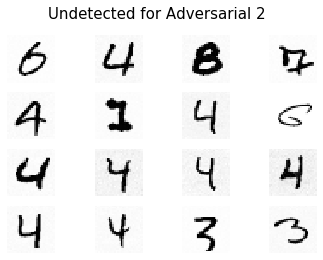

In [8]:
fig, axs = plt.subplots(4, 4)

maximum = len(undetected)
i = 0
for row in range(4):
    for col in range(4):
        if i >= len(undetected):
            axs[row][col].set_visible(False)
        else:
            axs[row][col].imshow(undetected[i].reshape((28, 28)), cmap='Greys')
        i += 1

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.axis('off')
    
fig.suptitle('Undetected for Adversarial 2', fontsize='15')

# plt.savefig('und_adv2.png')